In [1]:
import sklearn
import dicom
import os
import numpy as np
import pylab  
import nibabel as nib
import cv2
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import random
import time
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
%matplotlib inline

ROIx = 300
ROIy = 350
ROIhw = 40

/home/tylab/.local/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
def npmin(dd):
    return np.min(dd)
def npmax(dd):
    return np.max(dd)
def npmean(dd):
    return np.mean(dd)
def norm (data): 
    return (data - npmin(data)) / (npmax(data) - npmin(data))*1

In [3]:
data_filepath = "../../../CT_image_GAN/datasets/data/CAO_ZHAN_YUAN_10686240_19609_005_SY_Cardiac_step_infant_Cardiac_45_0%.nii"
data = nib.load(data_filepath)
data_array = data.get_data()
print (data_array.shape)
data_array = data_array.transpose(0, 2, 1)
data_array = data_array.transpose(1, 0, 2)
print (data_array.shape)
whole_data = norm(data_array) 


(512, 512, 245)
(245, 512, 512)


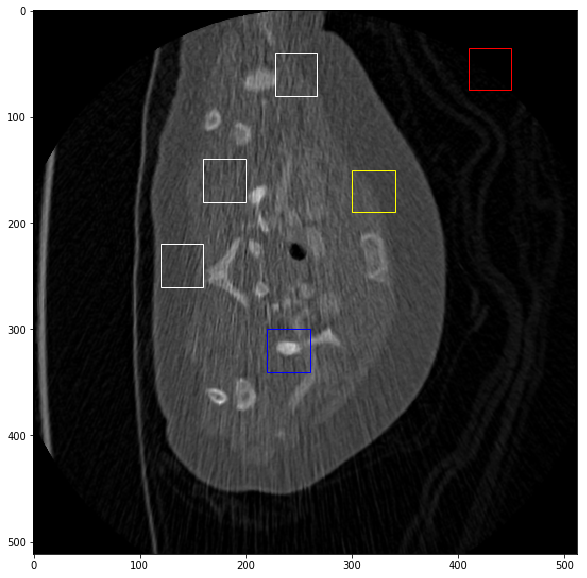

In [4]:
fig = plt.figure(figsize=(20, 10))

rect1 = patches.Rectangle((410, 35), ROIhw, ROIhw, linewidth=1, edgecolor="red", facecolor="none")
rect2 = patches.Rectangle((220, 300), ROIhw, ROIhw, linewidth=1, edgecolor="blue", facecolor="none")
rect3 = patches.Rectangle((300, 150), ROIhw, ROIhw, linewidth=1, edgecolor="yellow", facecolor="none")
rect4 = patches.Rectangle((120, 220), ROIhw, ROIhw, linewidth=1, edgecolor="white", facecolor="none")
rect5 = patches.Rectangle((227, 40), ROIhw, ROIhw, linewidth=1, edgecolor="white", facecolor="none")
rect6 = patches.Rectangle((160, 140), ROIhw, ROIhw, linewidth=1, edgecolor="white", facecolor="none")

plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)
plt.gca().add_patch(rect4)
plt.gca().add_patch(rect5)
plt.gca().add_patch(rect6)

plt.imshow(whole_data[220], cmap=pylab.cm.gray, vmin=0, vmax=1)
plt.show()

In [5]:
def flip_matrix(m):
    m_flip_lr = np.zeros(shape = m.shape)
    m_flip_ud = np.zeros(shape = m.shape)
    for i, item in enumerate(m):
        m_flip_lr[i] = np.flip(m[i], axis = 1)
        m_flip_ud[i] = np.flip(m[i], axis = 0)
    m_flip = np.vstack((m_flip_lr, m_flip_ud))
    return m_flip
        
def rotate_matrix(m, times):
    m_rotate = np.zeros(shape = m.shape)
    for i, item in enumerate(m):
        m_rotate[i] = np.rot90(m[i], k = times, axes = (0,1))
    return m_rotate
        
def label_matrix(num, label):
    m_label = np.zeros([num,2])
    for i in range(num):
        m_label[i][label] = 1
    return m_label
        
def augment_matrix(m):
    m_flip = flip_matrix(m)
    m1 = np.vstack((m, m_flip))
    m2 = m1
    for i in range(1, 4):
        tmp = rotate_matrix(m1, i)
        m2 = np.vstack((m2, tmp))
    return m2  

fig = plt.figure(figsize=(10, 10))
img = whole_data[220]
'''original a_ROI'''
x = np.array([245, 290, 115])
y = np.array([395, 365, 265])
a_ROI = np.zeros(shape = (x.shape[0],ROIhw, ROIhw))
for i, item in enumerate(x):
    a_ROI[i] = img[y[i]: y[i]+ROIhw, x[i]: x[i]+ROIhw]
    
a_ROI_aug = augment_matrix(a_ROI)
a_ROI_aug_label = label_matrix(a_ROI_aug.shape[0], 0)

'''original o_ROI'''
x = np.array([280, 160, 342, 0])
y = np.array([340, 230, 130, 0])
o_ROI = np.zeros(shape = (x.shape[0],ROIhw, ROIhw))
for i, item in enumerate(x):
    o_ROI[i] = img[y[i]: y[i]+ROIhw, x[i]: x[i]+ROIhw]
    
o_ROI_aug = augment_matrix(o_ROI)
o_ROI_aug_label = label_matrix(o_ROI_aug.shape[0], 1)

train_data = np.vstack((a_ROI_aug, o_ROI_aug))
train_label = np.vstack((a_ROI_aug_label, o_ROI_aug_label))
print (train_data.shape)
print (train_label.shape)

(84, 40, 40)
(84, 2)


<Figure size 720x720 with 0 Axes>

In [6]:
with tf.name_scope("input") as scope:
    input_x = tf.placeholder(tf.float32, [None, ROIhw, ROIhw])/255
    output_y = tf.placeholder(tf.int32, [None, 2])
    input_x_img = tf.reshape(input_x, [-1, ROIhw, ROIhw, 1])

In [7]:
def conv2(x, f, ks, s):
    return tf.layers.conv2d(
        inputs = x,
        filters = f,
        kernel_size = ks,
        strides = s,
        padding = 'same',
        activation = tf.nn.relu
    )

def max_pool(x, ks, s):
    return tf.layers.max_pooling2d(
        inputs = x,
        pool_size = ks,
        strides = s
    )

In [8]:
with tf.name_scope("network") as scope:
    conv2_1 = conv2(input_x_img, 32, [5, 5], 1)
    pool_1 = max_pool(conv2_1, [2, 2], 2)
    print (pool_1.shape)

    conv2_2 = conv2(pool_1, 32, [5, 5], 1)
    pool_2 = max_pool(conv2_2, [2, 2], 2)
    print (pool_2.shape)

    conv2_3 = conv2(pool_2, 32, [5, 5], 1)
    pool_3 = max_pool(conv2_3, [2, 2], 2)
    print (pool_3.shape)
    flat = tf.reshape(pool_3, [-1, pool_3.shape[1]*pool_3.shape[2]*pool_3.shape[3]])
    print (flat.shape)

    dense = tf.layers.dense(
            inputs = flat,
            units = 1024,
            activation = tf.nn.relu
    )

    keep_prob = tf.placeholder(tf.float32)
    dropout = tf.layers.dropout(
            inputs = dense, rate = keep_prob)

    logits = tf.layers.dense(
            inputs = dropout, units = 2)

(?, 20, 20, 32)
(?, 10, 10, 32)
(?, 5, 5, 32)
(?, 800)


In [9]:
with tf.name_scope("loss_func") as scope:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=output_y, logits=logits))

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(output_y, 1))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
with tf.name_scope("train_op") as scope:
    train_op = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

In [11]:
sess = tf.Session()
init = tf.group(tf.global_variables_initializer(),
               tf.local_variables_initializer())
sess.run(init)

In [12]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [13]:
train_d, test_data, train_l, test_label = train_test_split(train_data, train_label, test_size=0.4, random_state=0)
print (train_d.shape)
print (train_l.shape)
print (test_data.shape)
print (test_label.shape)

for i in range(1600):
    b0, b1 = next_batch(40, train_d, train_l)
    train_loss, train_op_ = sess.run((loss, train_op), feed_dict = {input_x:b0, output_y:b1})
    if i%100 == 0:
        train_accuracy = sess.run(accuracy_op, {input_x: b0, output_y:b1, keep_prob: 0.5})
        print ("Step: %d, train loss = %4f, accuracy = %2f)"%(i, train_loss, train_accuracy))

(50, 40, 40)
(50, 2)
(34, 40, 40)
(34, 2)
Step: 0, train loss = 0.693776, accuracy = 0.375000)
Step: 100, train loss = 0.693599, accuracy = 0.550000)
Step: 200, train loss = 0.693300, accuracy = 0.625000)
Step: 300, train loss = 0.692938, accuracy = 0.725000)
Step: 400, train loss = 0.692906, accuracy = 0.650000)
Step: 500, train loss = 0.692477, accuracy = 0.675000)
Step: 600, train loss = 0.692816, accuracy = 0.600000)
Step: 700, train loss = 0.692182, accuracy = 0.650000)
Step: 800, train loss = 0.691736, accuracy = 0.675000)
Step: 900, train loss = 0.691896, accuracy = 0.650000)
Step: 1000, train loss = 0.691339, accuracy = 0.675000)
Step: 1100, train loss = 0.691082, accuracy = 0.700000)
Step: 1200, train loss = 0.691163, accuracy = 0.675000)
Step: 1300, train loss = 0.691434, accuracy = 0.625000)
Step: 1400, train loss = 0.690369, accuracy = 0.700000)
Step: 1500, train loss = 0.690706, accuracy = 0.675000)


In [14]:
for i in range(20):
    b0, b1 = next_batch(20, test_data, test_label)
    train_loss = sess.run(loss, feed_dict = {input_x:b0, output_y:b1})
    train_accuracy = sess.run(accuracy_op, {input_x: b0, output_y:b1, keep_prob: 1.0})
    print ("test Step: %d, test loss = %4f, accuracy = %2f)"%(i, train_loss, train_accuracy))

test Step: 0, test loss = 0.693152, accuracy = 0.450000)
test Step: 1, test loss = 0.691811, accuracy = 0.550000)
test Step: 2, test loss = 0.692173, accuracy = 0.500000)
test Step: 3, test loss = 0.690813, accuracy = 0.600000)
test Step: 4, test loss = 0.693813, accuracy = 0.400000)
test Step: 5, test loss = 0.690320, accuracy = 0.650000)
test Step: 6, test loss = 0.693187, accuracy = 0.450000)
test Step: 7, test loss = 0.692278, accuracy = 0.500000)
test Step: 8, test loss = 0.692182, accuracy = 0.500000)
test Step: 9, test loss = 0.691958, accuracy = 0.550000)
test Step: 10, test loss = 0.689386, accuracy = 0.700000)
test Step: 11, test loss = 0.692530, accuracy = 0.500000)
test Step: 12, test loss = 0.693817, accuracy = 0.400000)
test Step: 13, test loss = 0.690030, accuracy = 0.650000)
test Step: 14, test loss = 0.691958, accuracy = 0.550000)
test Step: 15, test loss = 0.693997, accuracy = 0.400000)
test Step: 16, test loss = 0.692417, accuracy = 0.500000)
test Step: 17, test loss

In [15]:
def cut(im):
    '''
    切出整張CT所有patch
    return img_patches:所有patch的list
    '''
    img_patches = []
    x1 = 0
    y1 = 0
    x2 = ROIhw
    y2 = ROIhw

    while x2 <= 512:
        while y2 <= 512:
            img_patches.append(im[y1:y2,x1:x2])
            y1 = y1 + 4
            y2 = y1 + ROIhw
        x1 = x1 + 4
        x2 = x1 + ROIhw
        y1 = 0
        y2 = ROIhw

    return np.array(img_patches)

In [16]:
CT_to_cut = np.array(whole_data[220])
whole_patches = cut(CT_to_cut)
print (whole_patches.shape)

(14161, 40, 40)


In [17]:
data_img_logits = sess.run(logits, {input_x: whole_patches, keep_prob: 1.0})

In [27]:
max_l = np.max(data_img_logits[:][0])
artifacts = []
for i in range(np.array(data_img_logits).shape[0]):
    if data_img_logits[i][0]> max_l*0.5 and data_img_logits[i][0]>data_img_logits[i][1]:
        if np.max(whole_patches[i])<=0.4 and np.min(whole_patches[i]) > 0.05:
            artifacts.append(whole_patches[i])
        
print (np.array(artifacts).shape)

(925, 40, 40)


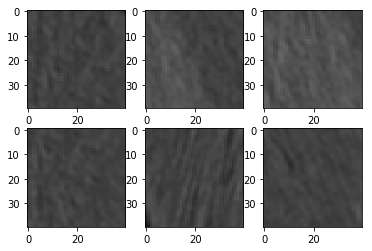

In [28]:
import random
for i in range(6):
    l = np.array(artifacts).shape[0]
    r = random.randint(0,l-1)
    plt.subplot(2,3,i+1)
    plt.imshow(artifacts[r], cmap=pylab.cm.gray, vmin=0, vmax=1)

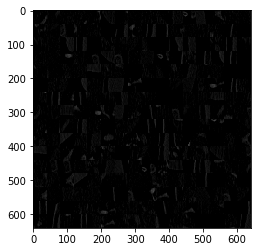

In [26]:
new_a_I = new_a*0.6
plt.imshow(new_a_I, cmap=pylab.cm.gray, vmin=0, vmax=1)
plt.show()

(256, 40, 40)


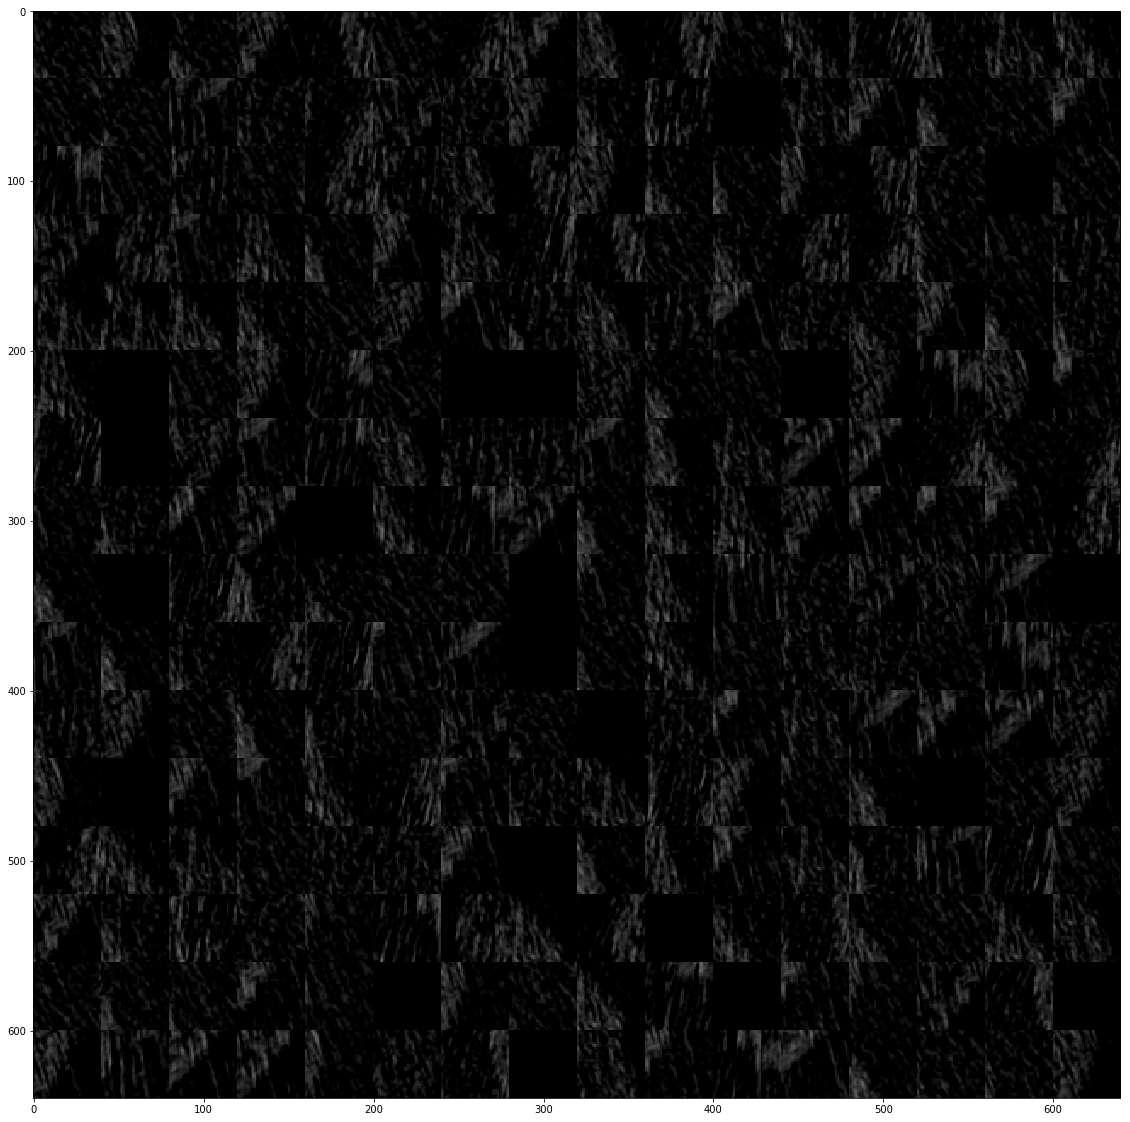

In [32]:
def noise(a,n):
    mean = np.mean(a)
    b = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in range(n):
            tmp = a[i][j] - mean
            if tmp>0:b[i][j] = tmp
    return b

def merge_patch(rois):
    pick = []
    l = np.array(rois).shape[0]
    for i in range(16*16):
        c_a = random.randint(0,9)
        if(c_a==0):
            pick.append(np.zeros((np.array(rois).shape[1],np.array(rois).shape[2])))
        else:
            idx = random.randint(0,l-1)
            a = noise(rois[idx],40)
            pick.append(a)
    print(np.array(pick).shape)
    
    for i in range(16):
        c = pick[i*16]
        for j in range(15):
            ind = i*16+1
            c = np.hstack((c, pick[ind+j]))
        if i==0: d = c
        else: d = np.vstack((d,c))
    return np.array(d)

new_a = merge_patch(artifacts)

fig = plt.figure(figsize=(20, 20))
plt.imshow(new_a, cmap=pylab.cm.gray, vmin=0, vmax=0.3)
plt.show()

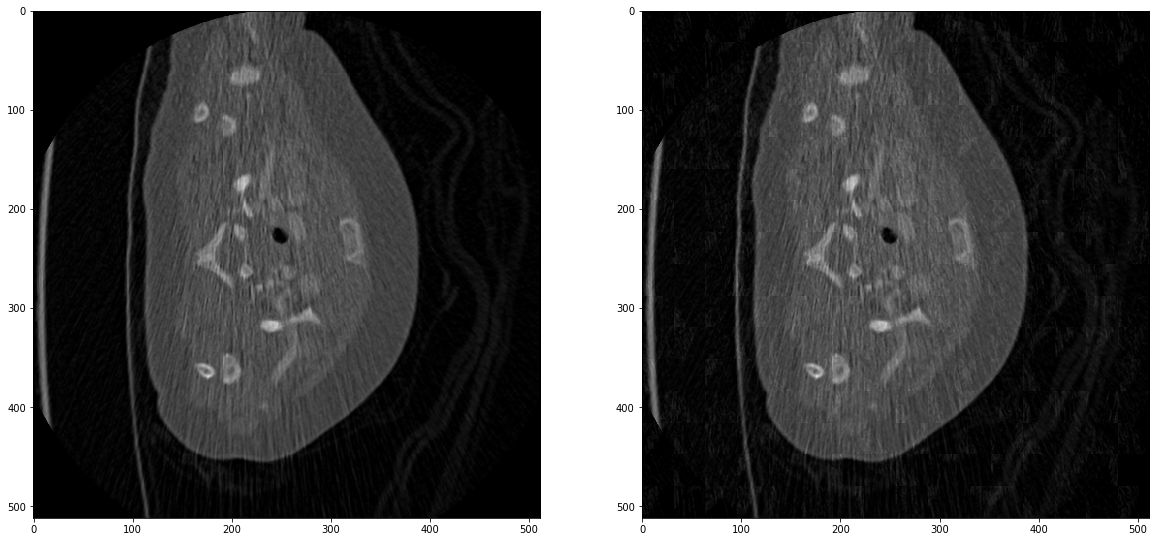

In [36]:
ct_im = whole_data[220]
new = cv2.resize(new_a, (512, 512), interpolation = cv2.INTER_CUBIC)
ct_a = ct_im + new
fig = plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(ct_im, cmap=pylab.cm.gray, vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(ct_a, cmap=pylab.cm.gray, vmin=0, vmax=1)